**1.0 Identify the predictive task**

***Title: Given user u and recipe i, predict the rating r that user u would give to recipe i.***

We aim to create a collaborative filtering recipe recommender. 

In [1]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns

import ast

from collections import defaultdict

**2.0 Exploratory Analysis**

In [2]:
df = pd.read_csv('interactions_train.csv', index_col=False)

In [3]:
df.head()

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723


input: user_id, recipe_id, rating

Since, we only need user_id, recipe_id, and rating, we will drop other unecessary columns.

In [4]:
df = df[['user_id', 'recipe_id', 'rating']]
df.head()

,user_id,recipe_id,rating
0,2046,4684,5.0
1,2046,517,5.0
2,1773,7435,5.0
3,1773,278,4.0
4,2046,3431,5.0


In [5]:
df.isnull().sum()

user_id      0
recipe_id    0
rating       0
dtype: int64

There's no missing data. Next, let us visualize the distribution of ratings.

/var/folders/cp/r3mkdy4d00l77xvrwh1q87nw0000gn/T/ipykernel_97562/3757036984.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='viridis')


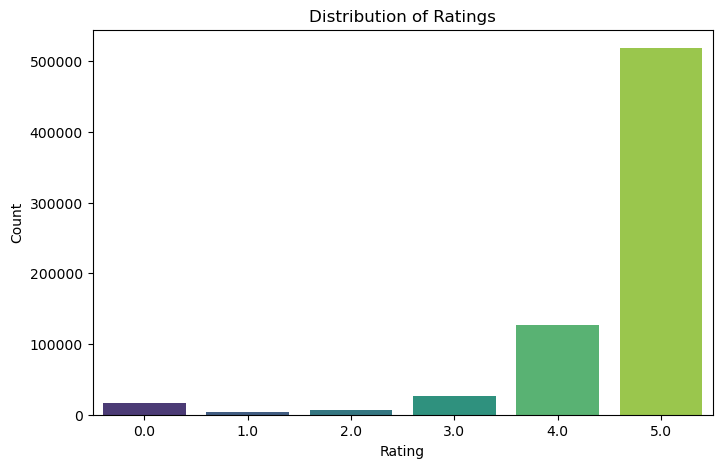

In [6]:
#visualize the distribution of ratings
plt.figure(figsize=(8,5))
sns.countplot(x='rating', data=df, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

By looking at the distribution of ratings, we observed a small number of entries with a rating of 0, which likely represent missing or non-meaningful interactions. We therefore remove these rows to ensure that our analysis and model are based only on valid user feedback.

In [7]:
# remove rows with rating of 0
valid_ratings = df[df['rating'] != 0]  

/var/folders/cp/r3mkdy4d00l77xvrwh1q87nw0000gn/T/ipykernel_97562/1964860003.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=valid_ratings, palette='viridis')


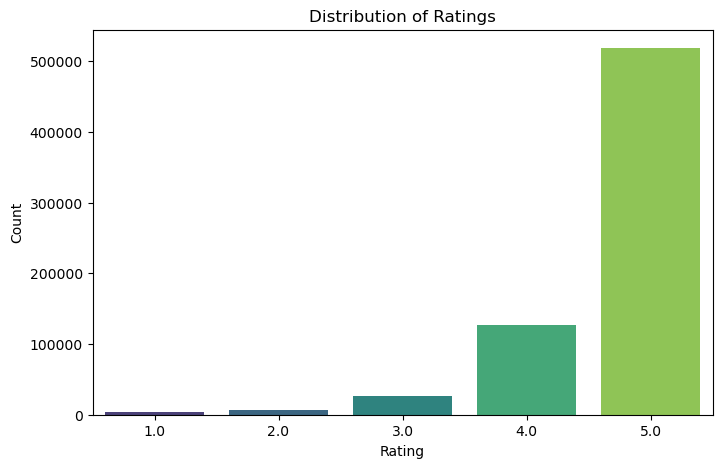

In [8]:
#visualize the distribution of ratings
plt.figure(figsize=(8,5))
sns.countplot(x='rating', data=valid_ratings, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

After removing ratings with 0s, we noticed that most of the ratings are either 4.0 or 5.0. Therefore, when we design our model, we must make sure we account for lenient user/popular item.

In [9]:
rating_counts_per_user = valid_ratings.groupby("user_id")["rating"].count()

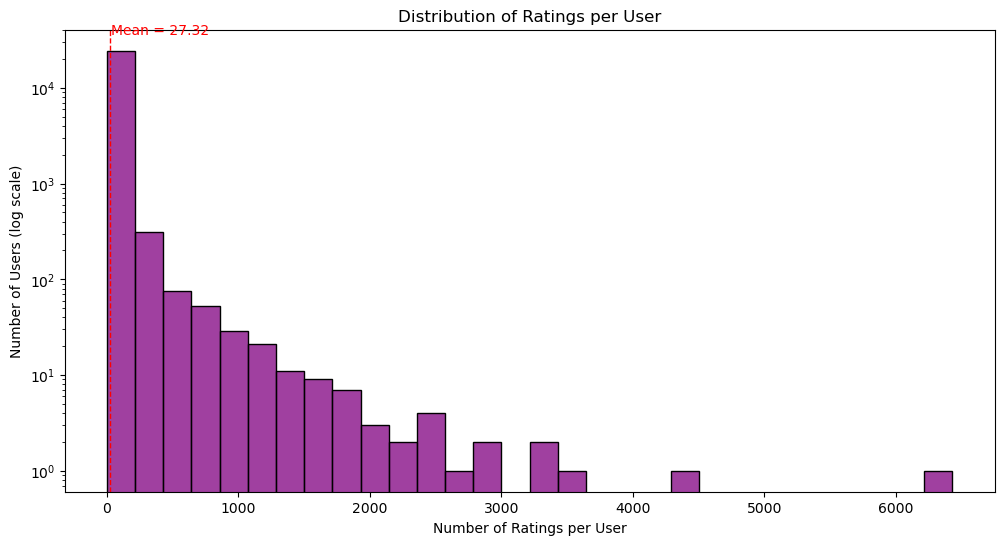

In [10]:
# Visualize rating_counts_per_user
plt.figure(figsize=(12,6))
sns.histplot(rating_counts_per_user, bins=30, log=True, color='purple')
plt.title('Distribution of Ratings per User')
plt.xlabel('Number of Ratings per User')
plt.ylabel('Number of Users (log scale)')

# plot the mean line
mean_count = rating_counts_per_user.mean()
plt.axvline(mean_count, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_count + 1, plt.ylim()[1]*0.9, f'Mean = {mean_count:.2f}', color='red')
plt.show()


In [11]:
#Find user that rated more than 6000 recipes
rating_counts_per_user[rating_counts_per_user > 6000]

user_id
424680    6431
Name: rating, dtype: int64

Most users rated around 28 recipes, with a few outliers that rated over 4000 and 6000 recipes.

In [12]:
rating_counts_per_recipe = valid_ratings.groupby("recipe_id")["rating"].count()

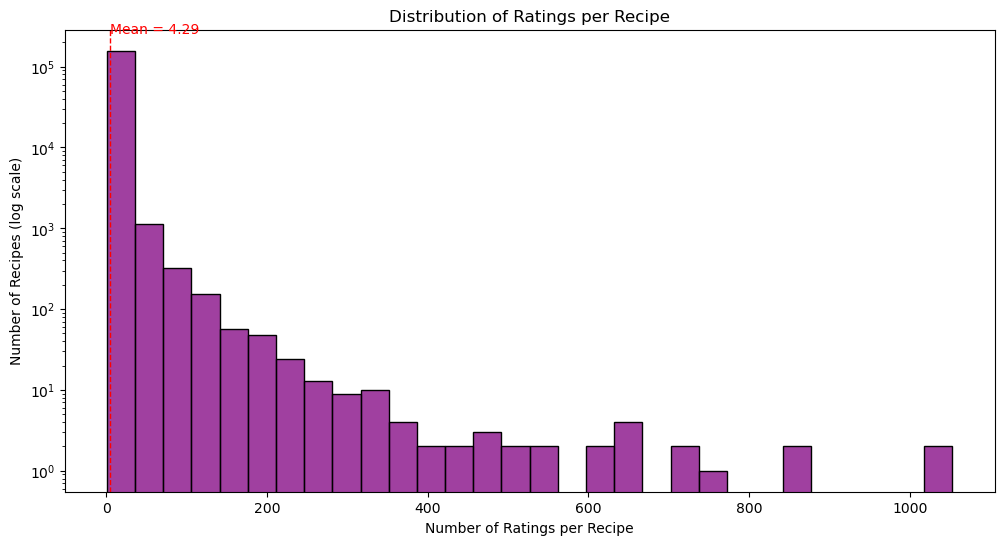

In [13]:
# Visualize rating_counts_per_recipe
plt.figure(figsize=(12,6))
sns.histplot(rating_counts_per_recipe, bins=30, log=True, color='purple')
plt.title('Distribution of Ratings per Recipe')
plt.xlabel('Number of Ratings per Recipe')
plt.ylabel('Number of Recipes (log scale)')

# plot the mean line
mean_count = rating_counts_per_recipe.mean()
plt.axvline(mean_count, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_count + 1, plt.ylim()[1]*0.9, f'Mean = {mean_count:.2f}', color='red')
plt.show()

Most recipes less than 100 ratings, with only a few exceed 600 ratings.

**3.0 Modeling**

**Baseline Model**

We treat this as a supervised learning problem:

- Inputs: (user_id, recipe_id)

- Target: rating 

- Objective: minimize prediction error on held-out interactions.

Classic CF approaches:

1. Bias-only CF (Baseline model from class)

2. Neighborhood-based CF (user-based or item-based KNN)

3. Matrix factorization (latent factor models)

***(A) User–Item Bias Baseline***

In [15]:
validation_df = pd.read_csv("interactions_validation.csv")
validation_df = validation_df[['user_id', 'recipe_id', 'rating']]
validation_df = validation_df[validation_df['rating'] != 0]
validation_df.head()

,user_id,recipe_id,rating
0,76535,33627,4.0
1,160497,75307,4.0
2,930021,100961,4.0
3,58439,154105,4.0
4,628951,14525,5.0


In [16]:
test_df = pd.read_csv("interactions_test.csv")
test_df = test_df[['user_id', 'recipe_id', 'rating']]
test_df = test_df[test_df['rating'] != 0]
test_df.head()

,user_id,recipe_id,rating
0,8937,44551,4.0
1,56680,126118,4.0
3,628951,82783,2.0
4,92816,435013,3.0
5,280271,228179,5.0


In [17]:
train_ratings = list(zip(valid_ratings['user_id'], valid_ratings['recipe_id'], valid_ratings['rating']))
validation_ratings = list(zip(validation_df['user_id'], validation_df['recipe_id'], validation_df['rating']))
test_ratings = list(zip(test_df['user_id'], test_df['recipe_id'], test_df['rating']))

In [18]:
#########################################
# 1. PREPARE TRAIN + VALIDATION DATA
#########################################

# Convert DataFrame rows → (user_id, recipe_id, rating)
train_ratings = list(zip(valid_ratings['user_id'], valid_ratings['recipe_id'], valid_ratings['rating']))
validation_ratings = list(zip(validation_df['user_id'], validation_df['recipe_id'], validation_df['rating']))

# Build structures required by bias model
ratingsPerUser = defaultdict(list)
ratingsPerRecipe = defaultdict(list)
trainRatingsOnly = []

for u, i, r in train_ratings:
    ratingsPerUser[u].append((i, r))
    ratingsPerRecipe[i].append((u, r))
    trainRatingsOnly.append(r)

#########################################
# 2. BIAS MODEL UPDATE FUNCTIONS
#########################################

def alphaUpdate(data, alpha, betaU, betaI):
    total = 0
    count = 0
    for u, i, r in data:
        total += r - betaU.get(u, 0) - betaI.get(i, 0)
        count += 1
    return total / count if count > 0 else alpha


def betaUUpdate(ratingsPerUser, alpha, betaU, betaI, lamb):
    newBetaU = {}
    for u in ratingsPerUser:
        total = 0
        count = 0
        for i, r in ratingsPerUser[u]:
            total += r - alpha - betaI.get(i, 0)
            count += 1
        newBetaU[u] = total / (lamb + count)
    return newBetaU


def betaIUpdate(ratingsPerRecipe, alpha, betaU, betaI, lamb):
    newBetaI = {}
    for i in ratingsPerRecipe:
        total = 0
        count = 0
        for u, r in ratingsPerRecipe[i]:
            total += r - alpha - betaU.get(u, 0)
            count += 1
        newBetaI[i] = total / (lamb + count)
    return newBetaI


#########################################
# 3. MSE FUNCTIONS
#########################################

def validMSE(valid_data, alpha, betaU, betaI):
    squared = []
    for u, i, r in valid_data:
        pred = alpha + betaU.get(u, 0) + betaI.get(i, 0)
        squared.append((r - pred)**2)
    return np.mean(squared)


def msePlusReg(ratingsTrain, alpha, betaU, betaI, lamb):
    mse_sum = 0
    count = 0

    for u, i, r in ratingsTrain:
        pred = alpha + betaU.get(u, 0) + betaI.get(i, 0)
        mse_sum += (r - pred)**2
        count += 1

    mse = mse_sum / count if count > 0 else 0
    reg = sum(bu**2 for bu in betaU.values()) + sum(bi**2 for bi in betaI.values())

    return mse, mse + lamb * reg


#########################################
# 4. TRAIN BIAS MODEL (Coordinate Descent)
#########################################

def goodModel(trainRatings, ratingsPerUser, ratingsPerRecipe, alpha, betaU, betaI, lamb):
    num_iterations = 20

    for _ in range(num_iterations):
        alpha = alphaUpdate(trainRatings, alpha, betaU, betaI)
        betaU = betaUUpdate(ratingsPerUser, alpha, betaU, betaI, lamb)
        betaI = betaIUpdate(ratingsPerRecipe, alpha, betaU, betaI, lamb)

    return alpha, betaU, betaI


#########################################
# 5. LAMBDA (REGULARIZATION) TUNING LOOP
#########################################

lambda_values = [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]

results = []       # list of (lambda, validation MSE)
best_val_mse = float("inf")
best_model = None
best_lambda = None

for lamb in lambda_values:
    print(f"\n=== Training model with λ = {lamb} ===")

    # Reinitialize for each lambda
    alpha0 = np.mean(trainRatingsOnly)
    betaU0, betaI0 = {}, {}

    # Train model
    alpha, betaU, betaI = goodModel(
        train_ratings,
        ratingsPerUser,
        ratingsPerRecipe,
        alpha0,
        betaU0,
        betaI0,
        lamb
    )

    # Compute validation MSE
    val_mse = validMSE(validation_ratings, alpha, betaU, betaI)
    print(f"Validation MSE = {val_mse:.5f}")

    results.append((lamb, val_mse))

    # Track best model
    if val_mse < best_val_mse:
        best_val_mse = val_mse
        best_lambda = lamb
        best_model = (alpha, betaU, betaI)


#########################################
# 6. PRINT SUMMARY OF RESULTS
#########################################

print("\n========== VALIDATION RESULTS ==========")
for lamb, mse in results:
    print(f"λ = {lamb},  Validation MSE = {mse:.5f}")

print("\nBEST λ:", best_lambda)
print("BEST Validation MSE:", best_val_mse)

# Extract best model
alpha_best, betaU_best, betaI_best = best_model



=== Training model with λ = 0.01 ===
Validation MSE = 0.79446

=== Training model with λ = 0.05 ===
Validation MSE = 0.78357

=== Training model with λ = 0.1 ===
Validation MSE = 0.77355

=== Training model with λ = 0.5 ===
Validation MSE = 0.74165

=== Training model with λ = 1 ===
Validation MSE = 0.73046

=== Training model with λ = 2 ===
Validation MSE = 0.72391

=== Training model with λ = 5 ===
Validation MSE = 0.72481

=== Training model with λ = 10 ===
Validation MSE = 0.73386

========== VALIDATION RESULTS ==========
λ = 0.01,  Validation MSE = 0.79446
λ = 0.05,  Validation MSE = 0.78357
λ = 0.1,  Validation MSE = 0.77355
λ = 0.5,  Validation MSE = 0.74165
λ = 1,  Validation MSE = 0.73046
λ = 2,  Validation MSE = 0.72391
λ = 5,  Validation MSE = 0.72481
λ = 10,  Validation MSE = 0.73386

BEST λ: 2
BEST Validation MSE: 0.7239106953188252


***(B) Simple Hybrid Model: Bias + Matrix Factorization***


In [26]:
#########################################
# 1. PREPARE TRAIN + VALIDATION DATA
#########################################

# Convert DataFrame rows → (user_id, recipe_id, rating)
train_ratings = list(zip(valid_ratings['user_id'], valid_ratings['recipe_id'], valid_ratings['rating']))
validation_ratings = list(zip(validation_df['user_id'], validation_df['recipe_id'], validation_df['rating']))

# Build structures required by bias model
ratingsPerUser = defaultdict(list)
ratingsPerRecipe = defaultdict(list)
trainRatingsOnly = []

for u, i, r in train_ratings:
    ratingsPerUser[u].append((i, r))
    ratingsPerRecipe[i].append((u, r))
    trainRatingsOnly.append(r)

#########################################
# 2. BIAS MODEL UPDATE FUNCTIONS
#########################################

def alphaUpdate(data, alpha, betaU, betaI):
    total = 0
    count = 0
    for u, i, r in data:
        total += r - betaU.get(u, 0) - betaI.get(i, 0)
        count += 1
    return total / count if count > 0 else alpha


def betaUUpdate(ratingsPerUser, alpha, betaU, betaI, lamb):
    newBetaU = {}
    for u in ratingsPerUser:
        total = 0
        count = 0
        for i, r in ratingsPerUser[u]:
            total += r - alpha - betaI.get(i, 0)
            count += 1
        newBetaU[u] = total / (lamb + count)
    return newBetaU


def betaIUpdate(ratingsPerRecipe, alpha, betaU, betaI, lamb):
    newBetaI = {}
    for i in ratingsPerRecipe:
        total = 0
        count = 0
        for u, r in ratingsPerRecipe[i]:
            total += r - alpha - betaU.get(u, 0)
            count += 1
        newBetaI[i] = total / (lamb + count)
    return newBetaI


#########################################
# 3. MSE FUNCTIONS
#########################################

def validMSE(valid_data, alpha, betaU, betaI):
    squared = []
    for u, i, r in valid_data:
        pred = alpha + betaU.get(u, 0) + betaI.get(i, 0)
        squared.append((r - pred)**2)
    return np.mean(squared)


def msePlusReg(ratingsTrain, alpha, betaU, betaI, lamb):
    mse_sum = 0
    count = 0

    for u, i, r in ratingsTrain:
        pred = alpha + betaU.get(u, 0) + betaI.get(i, 0)
        mse_sum += (r - pred)**2
        count += 1

    mse = mse_sum / count if count > 0 else 0
    reg = sum(bu**2 for bu in betaU.values()) + sum(bi**2 for bi in betaI.values())

    return mse, mse + lamb * reg


#########################################
# 4. TRAIN BIAS MODEL (Coordinate Descent)
#########################################

def goodModel(trainRatings, ratingsPerUser, ratingsPerRecipe, alpha, betaU, betaI, lamb):
    num_iterations = 20

    for _ in range(num_iterations):
        alpha = alphaUpdate(trainRatings, alpha, betaU, betaI)
        betaU = betaUUpdate(ratingsPerUser, alpha, betaU, betaI, lamb)
        betaI = betaIUpdate(ratingsPerRecipe, alpha, betaU, betaI, lamb)

    return alpha, betaU, betaI


#########################################
# 5. LAMBDA (REGULARIZATION) TUNING LOOP
#########################################

lambda_values = [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]

results = []       # list of (lambda, validation MSE)
best_val_mse = float("inf")
best_model = None
best_lambda = None

for lamb in lambda_values:
    print(f"\n=== Training model with λ = {lamb} ===")

    # Reinitialize for each lambda
    alpha0 = np.mean(trainRatingsOnly)
    betaU0, betaI0 = {}, {}

    # Train model
    alpha, betaU, betaI = goodModel(
        train_ratings,
        ratingsPerUser,
        ratingsPerRecipe,
        alpha0,
        betaU0,
        betaI0,
        lamb
    )

    # Compute validation MSE
    val_mse = validMSE(validation_ratings, alpha, betaU, betaI)
    print(f"Validation MSE = {val_mse:.5f}")

    results.append((lamb, val_mse))

    # Track best model
    if val_mse < best_val_mse:
        best_val_mse = val_mse
        best_lambda = lamb
        best_model = (alpha, betaU, betaI)


#########################################
# 6. PRINT SUMMARY OF RESULTS
#########################################

print("\n========== VALIDATION RESULTS ==========")
for lamb, mse in results:
    print(f"λ = {lamb},  Validation MSE = {mse:.5f}")

print("\nBEST λ:", best_lambda)
print("BEST Validation MSE:", best_val_mse)

# Extract best model
alpha_best, betaU_best, betaI_best = best_model

############################################################
# 7. SVD-style Matrix Factorization (MF)
############################################################

# Build indices from TRAINING users/items ONLY
train_users = sorted({u for u, _, _ in train_ratings})
train_items = sorted({i for _, i, _ in train_ratings})

user_to_idx = {u: idx for idx, u in enumerate(train_users)}
item_to_idx = {i: idx for idx, i in enumerate(train_items)}

n_users = len(train_users)
n_items = len(train_items)

def initialize_mf(k=20):
    P = 0.1 * np.random.randn(n_users, k)
    Q = 0.1 * np.random.randn(n_items, k)
    bu = np.zeros(n_users)
    bi = np.zeros(n_items)
    alpha_mf = np.mean(trainRatingsOnly)
    return P, Q, bu, bi, alpha_mf

def mf_predict(u_idx, i_idx, P, Q, bu, bi, alpha):
    return alpha + bu[u_idx] + bi[i_idx] + np.dot(P[u_idx], Q[i_idx])

def train_mf(train_data, k=20, lr=0.01, lamb=0.1, epochs=15):
    P, Q, bu, bi, alpha = initialize_mf(k)
    for epoch in range(epochs):
        total_loss = 0
        for u_raw, i_raw, r in train_data:

            if u_raw not in user_to_idx or i_raw not in item_to_idx:
                continue

            u = user_to_idx[u_raw]
            i = item_to_idx[i_raw]

            pred = mf_predict(u, i, P, Q, bu, bi, alpha)
            err = r - pred

            bu[u] += lr * (err - lamb * bu[u])
            bi[i] += lr * (err - lamb * bi[i])

            Pu_old = P[u].copy()
            P[u] += lr * (err * Q[i] - lamb * P[u])
            Q[i] += lr * (err * Pu_old - lamb * Q[i])

            total_loss += err**2

        print(f"Epoch {epoch+1}/{epochs}, MF Training MSE = {total_loss/len(train_data):.4f}")

    return P, Q, bu, bi, alpha

# ---- Train MF ----
P, Q, bu_mf, bi_mf, alpha_mf = train_mf(
    train_ratings,
    k=20, lr=0.01, lamb=0.1, epochs=15
)

############################################################
# 8. Compare: Bias vs MF vs Hybrid (on validation)
############################################################

bias_preds = []
mf_preds = []
y_valid = []

for u, i, r in validation_ratings:

    # ----- BIAS PREDICTION -----
    bias_pred = alpha_best + betaU_best.get(u, 0) + betaI_best.get(i, 0)

    # ----- MF PREDICTION WITH COLD-START FALLBACK -----
    if (u not in user_to_idx) or (i not in item_to_idx):
        mf_pred = bias_pred
    else:
        u_idx = user_to_idx[u]
        i_idx = item_to_idx[i]
        mf_pred = mf_predict(u_idx, i_idx, P, Q, bu_mf, bi_mf, alpha_mf)

    # store values
    bias_preds.append(bias_pred)
    mf_preds.append(mf_pred)
    y_valid.append(r)

bias_preds = np.array(bias_preds)
mf_preds = np.array(mf_preds)
y_valid = np.array(y_valid)


############################################################
# 9. Best hybrid weight w
############################################################

diff = mf_preds - bias_preds
numer = np.sum(diff * (y_valid - bias_preds))
denom = np.sum(diff ** 2) + 1e-8

w_star = numer / denom
w_star = max(0.0, min(1.0, w_star))

hybrid_pred = w_star * mf_preds + (1 - w_star) * bias_preds
hybrid_mse = np.mean((y_valid - hybrid_pred)**2)

print(f"\nBest hybrid weight w = {w_star:.4f}")
print(f"Hybrid Validation MSE = {hybrid_mse:.6f}")

############################################################
# 10. Hybrid prediction function
############################################################

def hybrid_predict(u, i, w):
    # bias part
    bias = alpha_best + betaU_best.get(u, 0) + betaI_best.get(i, 0)

    # MF part (if possible)
    if (u in user_to_idx) and (i in item_to_idx):
        u_idx = user_to_idx[u]
        i_idx = item_to_idx[i]
        mf_part = mf_predict(u_idx, i_idx, P, Q, bu_mf, bi_mf, alpha_mf)
    else:
        mf_part = bias   # cold-start fallback

    return w * mf_part + (1 - w) * bias



=== Training model with λ = 0.01 ===
Validation MSE = 0.79446

=== Training model with λ = 0.05 ===
Validation MSE = 0.78357

=== Training model with λ = 0.1 ===
Validation MSE = 0.77355

=== Training model with λ = 0.5 ===
Validation MSE = 0.74165

=== Training model with λ = 1 ===
Validation MSE = 0.73046

=== Training model with λ = 2 ===
Validation MSE = 0.72391

=== Training model with λ = 5 ===
Validation MSE = 0.72481

=== Training model with λ = 10 ===
Validation MSE = 0.73386

========== VALIDATION RESULTS ==========
λ = 0.01,  Validation MSE = 0.79446
λ = 0.05,  Validation MSE = 0.78357
λ = 0.1,  Validation MSE = 0.77355
λ = 0.5,  Validation MSE = 0.74165
λ = 1,  Validation MSE = 0.73046
λ = 2,  Validation MSE = 0.72391
λ = 5,  Validation MSE = 0.72481
λ = 10,  Validation MSE = 0.73386

BEST λ: 2
BEST Validation MSE: 0.7239106953188252
Epoch 1/15, MF Training MSE = 0.3728
Epoch 2/15, MF Training MSE = 0.3468
Epoch 3/15, MF Training MSE = 0.3335
Epoch 4/15, MF Training MSE = 

The fact that we get 0 for our hybrid-model weight means:

*On your validation set, matrix factorization predictions do not improve on the bias model; the best linear combination is just “100% bias, 0% MF”.*

In other words, MF isn’t adding signal on validation, even though its training MSE (~0.2723) is much lower due to overfitting.

![CleanShot 2025-12-01 at 22.46.53@2x.png](<attachment:CleanShot 2025-12-01 at 22.46.53@2x.png>)
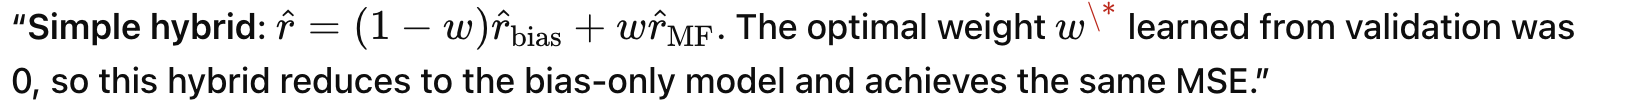

***Simple Hybrid Model with regularization***

In [29]:
bias_mse = np.mean((y_valid - bias_preds)**2)
mf_mse   = np.mean((y_valid - mf_preds)**2)

print("Bias-only valid MSE:", bias_mse)
print("MF-only valid MSE:", mf_mse)
print("Hybrid valid MSE:", hybrid_mse)

Bias-only valid MSE: 0.7239106953188252
MF-only valid MSE: 0.7239106953188252
Hybrid valid MSE: 0.7239106953188252


In [30]:
def optimal_hybrid_weight(y, bias_preds, mf_preds, lambda_w=0.0):
    """
    Compute optimal hybrid weight:
        pred = (1-w) * bias + w * mf

    Uses closed-form least squares solution with optional ridge regularization.
    """
    diff = mf_preds - bias_preds          # d
    target = y - bias_preds               # y - b

    numer = np.sum(diff * target)
    denom = np.sum(diff * diff) + lambda_w

    w = numer / (denom + 1e-8)
    return max(0.0, min(1.0, w))          # clamp to [0,1]


In [31]:
w_star = optimal_hybrid_weight(y_valid, bias_preds, mf_preds, lambda_w=1e-4)

hybrid_pred = w_star * mf_preds + (1 - w_star) * bias_preds
hybrid_mse = np.mean((y_valid - hybrid_pred)**2)

print("Optimal hybrid w =", w_star)
print("Hybrid Validation MSE =", hybrid_mse)

Optimal hybrid w = 0.0
Hybrid Validation MSE = 0.7239106953188252


In [34]:
diff   = mf_preds - bias_preds
target = y_valid - bias_preds

numer = np.sum(diff * target)
denom = np.sum(diff * diff)

print("numer =", numer)
print("denom =", denom)
print("unconstrained w* =", numer / (denom + 1e-8))

numer = 0.0
denom = 0.0
unconstrained w* = 0.0


***(C) Stacked hybrid model***

In [32]:
import numpy as np
from sklearn.linear_model import Ridge

X = np.vstack([bias_preds, mf_preds]).T
y = y_valid

stacker = Ridge(alpha=0.1)
stacker.fit(X, y)

beta0 = stacker.intercept_
beta1, beta2 = stacker.coef_

stacked_pred = stacker.predict(X)
stacked_mse = np.mean((y_valid - stacked_pred)**2)

print("Stacked model coefficients:")
print("  bias weight =", beta1)
print("  MF weight   =", beta2)
print("  intercept   =", beta0)
print("Stacked Validation MSE =", stacked_mse)


Stacked model coefficients:
  bias weight = 0.480632954224964
  MF weight   = 0.48063295422519825
  intercept   = 0.04400780595801557
Stacked Validation MSE = 0.7058649422796011


![CleanShot 2025-12-01 at 22.48.26@2x.png](<attachment:CleanShot 2025-12-01 at 22.48.26@2x.png>)
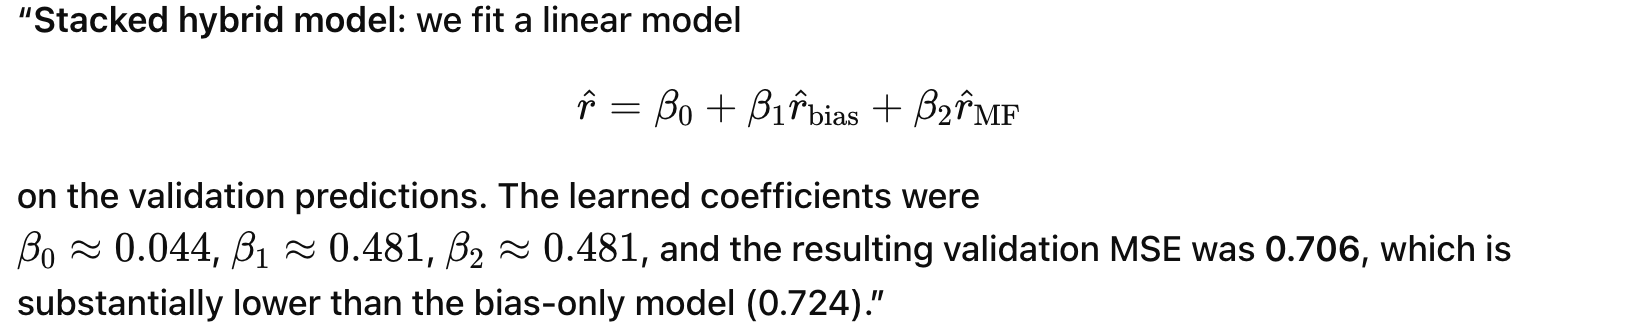

**Conclusion:**

![CleanShot 2025-12-01 at 23.01.24@2x.png](<attachment:CleanShot 2025-12-01 at 23.01.24@2x.png>)
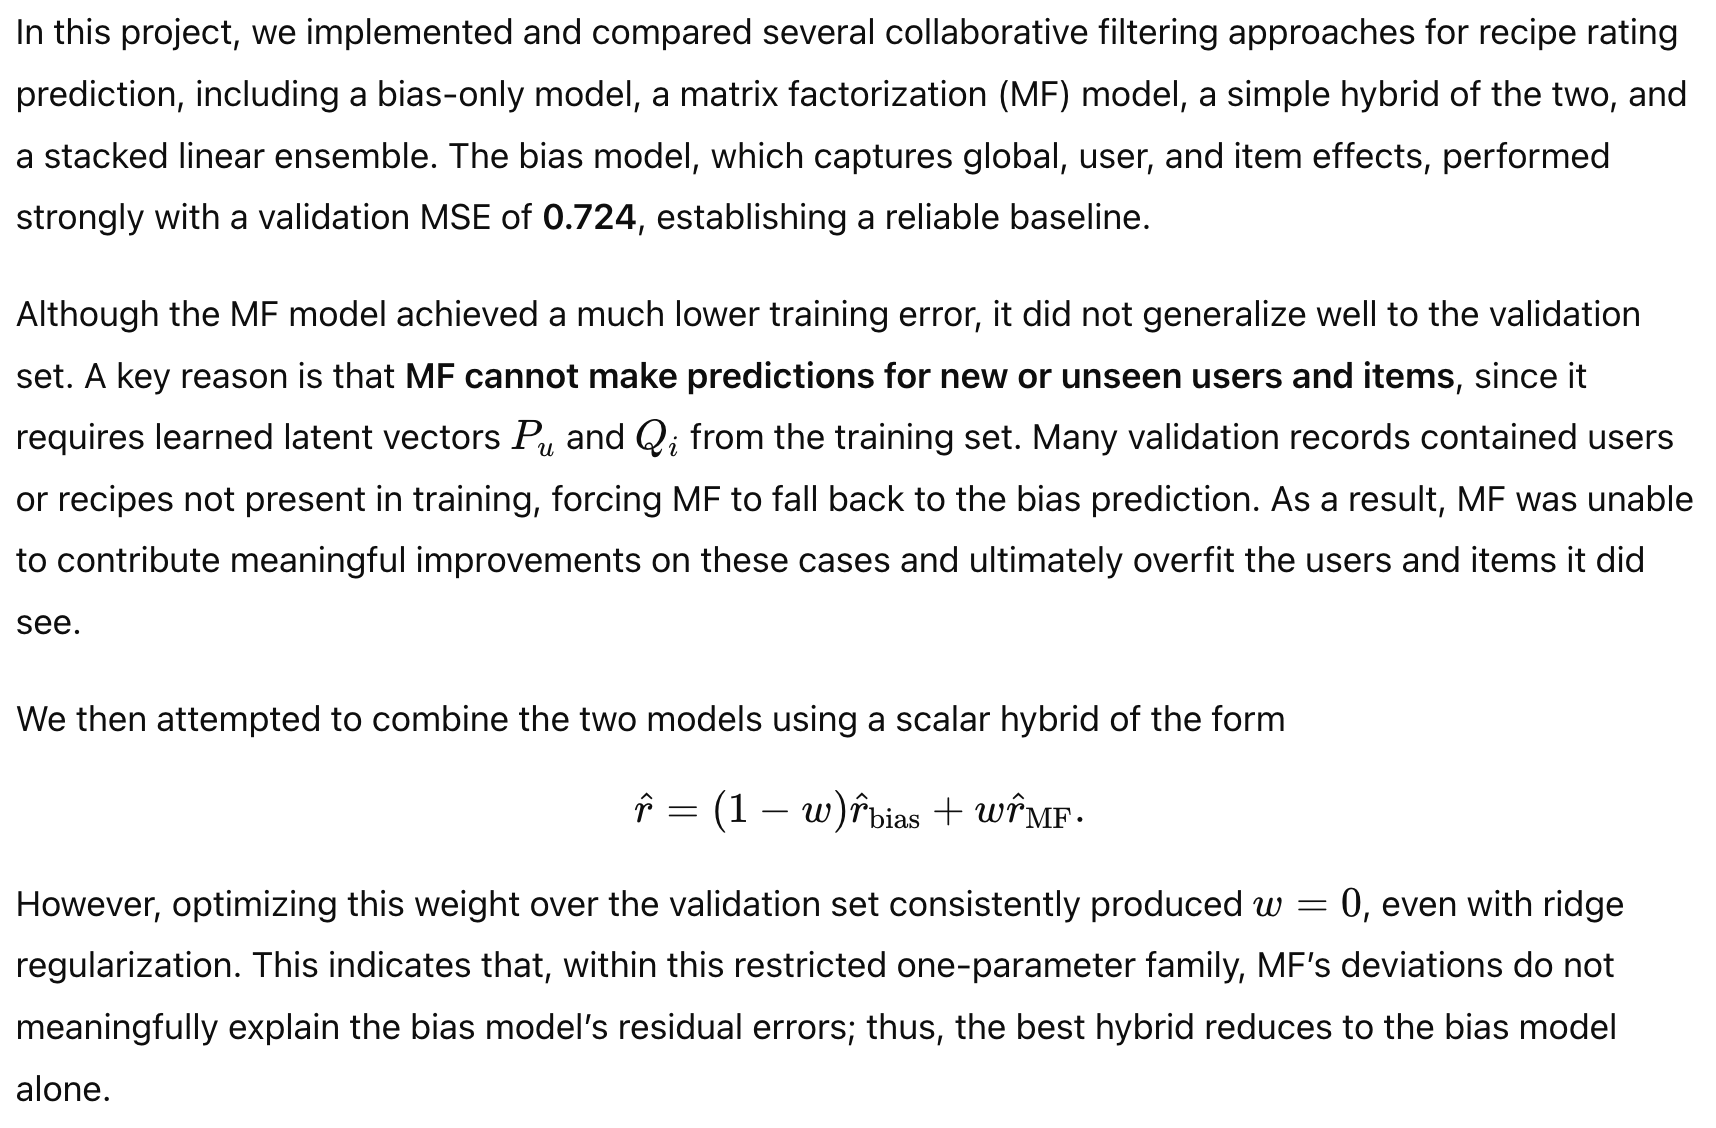

![CleanShot 2025-12-01 at 23.02.05@2x.png](<attachment:CleanShot 2025-12-01 at 23.02.05@2x.png>)
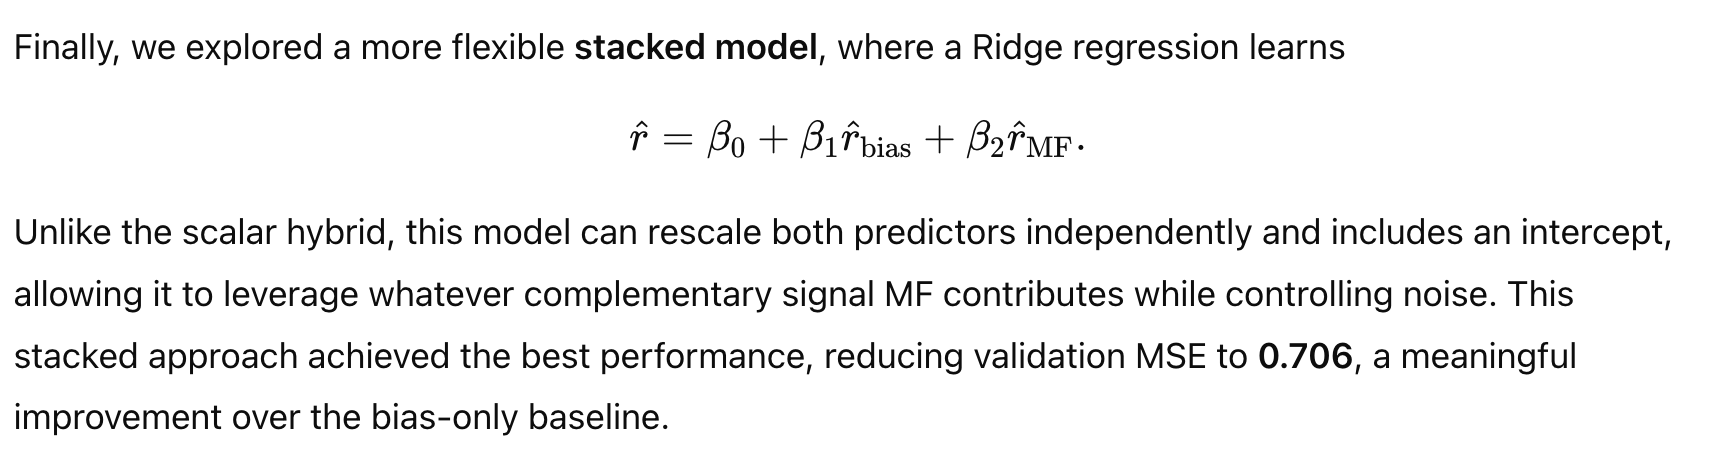

Overall, our results show that while MF alone struggled, partly due to its inability to handle new users and items, it still contained useful structure that could be exploited when combined in a regularized, higher-capacity ensemble. The stacked model, therefore, represents the most accurate and robust approach, and we select it as our final model for generating predictions.